In [2]:
import argparse
import numpy as np
from pprint import pprint
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
from torchvision import datasets, transforms
import os
from blackbox_utils import label_to_onehot, cross_entropy_for_onehot, pixelwise_euclidean_distance
import matplotlib.pyplot as plt
import matplotlib  # 关键：显式
from torch.utils.data import Dataset, DataLoader, Subset
# 指定使用文泉驿微米黑（系统已识别的字体名称）# 获取 matplotlib 缓存目录
cache_dir = matplotlib.get_cachedir()  
# 字体缓存文件名（不同版本可能为 fontlist-v330.json、fontlist.json 等）
font_cache = os.path.join(cache_dir, "fontlist.json")  

# 删除缓存文件
if os.path.exists(font_cache):
    os.remove(font_cache)
    print("✅ 已删除字体缓存，重启内核后生效！")
else:
    print("⚠️ 未找到字体缓存文件，可尝试重启内核。")
plt.rcParams['font.sans-serif'] = ['WenQuanYi Micro Hei']  
# 解决负号显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False  
##########sudo apt update && sudo apt install fonts-wqy-microhei -y  

/environment/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


⚠️ 未找到字体缓存文件，可尝试重启内核。


In [1]:
# ################################################
# ## 轻易不要运行这个代码

# import shutil

# # 配置路径
# source_root = "/home/featurize/data/University-Release/train/drone"
# target_dir = "/home/featurize/data/blackbox_data"

# # 确保目标文件夹存在
# if not os.path.exists(target_dir):
#     os.makedirs(target_dir)
#     print(f"创建目标文件夹: {target_dir}")

# # 定义支持的图片扩展名（可根据实际情况补充）
# IMAGE_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff')

# # 遍历所有子文件夹，提取图片
# copied_count = 0
# for root, dirs, files in os.walk(source_root):
#     for filename in files:
#         # 检查文件扩展名是否为图片
#         if filename.lower().endswith(IMAGE_EXTENSIONS):
#             source_path = os.path.join(root, filename)
#             # 处理重名：自动添加序号（如 photo.jpg → photo_1.jpg）
#             target_path = os.path.join(target_dir, filename)
#             if os.path.exists(target_path):
#                 base_name, ext = os.path.splitext(filename)
#                 counter = 1
#                 while True:
#                     new_filename = f"{base_name}_{counter}{ext}"
#                     target_path = os.path.join(target_dir, new_filename)
#                     if not os.path.exists(target_path):
#                         break
#                     counter += 1

#             # （可选）验证图片完整性，避免复制损坏文件
#             try:
#                 with Image.open(source_path) as img:
#                     img.verify()  # 验证图片是否可正常打开
#             except (IOError, SyntaxError) as e:
#                 print(f"跳过无效图片: {source_path}（错误: {e}）")
#                 continue

#             # 复制文件（保留元数据）
#             shutil.copy2(source_path, target_path)
#             ########### print(f"已复制: {source_path} → {target_path}")
#             copied_count += 1

# print(f"\n任务完成！共复制 {copied_count} 张图片到 {target_dir}")

NameError: name 'os' is not defined

In [3]:
# ------------------- 配置参数 -------------------
batchsize = 1
h, w = 384, 384
pad = 10
num_images = 3000  # 需要选取的照片数量
target_path = '/home/featurize/data/blackbox_data'  # 目标图片路径
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tt = transforms.ToTensor()#转发为张量
tp = transforms.ToPILImage()#转换为图片


数据集已限制为 3000 张照片


findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found 

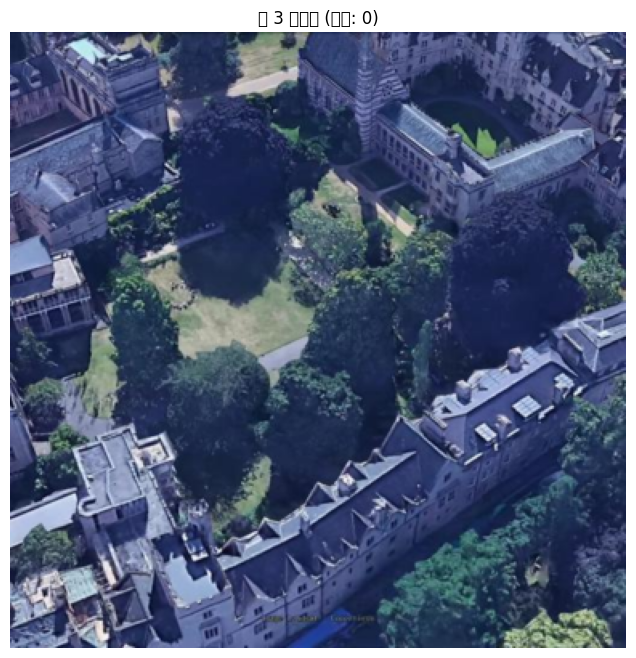

In [4]:
# 自定义数据集
class CustomImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        # 只保留图片文件
        self.image_paths = [
            os.path.join(image_dir, fname) 
            for fname in os.listdir(image_dir) 
            if fname.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))
            and not fname.startswith('.')
        ]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # 加载并返回 PIL 图像
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        
        # 应用预处理转换
        if self.transform:
            image = self.transform(image)
            
        return image, 0  # 返回预处理后的图像和标签 0

# 自定义 collate_fn
def custom_collate(batch):
    return batch[0]  # batch_size=1 时直接返回单个样本

# 定义图像预处理转换
transform = transforms.Compose([
    transforms.Resize((384, 384)),  # 调整图像大小为384×384
    transforms.ToTensor()         # 转换为张量
    # transforms.Normalize(           # 归一化处理
    #     mean=[0.485, 0.456, 0.406],  # ImageNet数据集的均值
    #     std=[0.229, 0.224, 0.225]    # ImageNet数据集的标准差
    
])

# 创建数据集和数据加载器
dataset = CustomImageDataset(target_path, transform=transform)
if len(dataset.image_paths) > 3000:
    dataset.image_paths = dataset.image_paths[:3000]
    print(f"数据集已限制为 {len(dataset.image_paths)} 张照片")
else:
    print(f"数据集共有 {len(dataset.image_paths)} 张照片，全部使用")


# 创建数据加载器（指定自定义 collate_fn）
dataloader = DataLoader(
    dataset,
    batch_size=1,  
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    collate_fn=custom_collate  # 关键修改
)

# 显示第三张照片
image_tensor, label = list(dataloader)[2]  # 获取第 3 张（索引 2）
image_pil = transforms.ToPILImage()(image_tensor)  # 转换回PIL图像用于显示

plt.figure(figsize=(8, 8))
plt.imshow(image_pil)
plt.title(f"第 3 张照片 (标签: {label})")
plt.axis('off')
plt.show()

In [5]:
# image, label = list(dataloader)[2]  # 索引 2 对应第三张照片
# plt.imshow(image)
# plt.show()

In [6]:

# # 转换为batch格式（添加batch维度，模型通常需要[batch, c, h, w]格式）
# preprocessed_img_torch = tt(preprocessed_img)
# preprocessed_img_torch = preprocessed_img_torch.unsqueeze(0)  # 形状从[c, h, w]变为[1, c, h, w]
# label_image_torch = torch.tensor([label_image])  # 标签添加batch维度



In [7]:
# from model_white_attack import ft_net
# pretrained_path = '/mnt/workspace/RK-Net/RK-Net-main/model/pretrain/net_359.pth'  # 绝对路径
# # RK-Net/RK-Net-main/model/pretrain/net_359.pth
# model = ft_net(751).to(device)

# # 加载预训练权重（strict=False允许部分参数不匹配，适用于迁移学习）
# pretrained_state = torch.load(pretrained_path, map_location=torch.device('cpu'))
# model.load_state_dict(pretrained_state, strict=False)
# print("Loaded pretrained model from:", pretrained_path)

| 索引 | 模块名称                          | 说明                          |
|------|-----------------------------------|-------------------------------|
| 0    | `model_ft.conv1`                  | 第1层：初始卷积层             |
| 1    | `model_ft.bn1`                    | 第2层：批归一化层             |
| 2    | `model_ft.relu`                   | 第3层：ReLU激活函数           |
| 3    | `self.usam_1`                     | 第4层：USAM注意力模块（第一个）|
| 4    | `model_ft.maxpool`                | 第5层：最大池化层             |
| 5    | `model_ft.layer1`                 | 第6层：ResNet第1个残差块      |
| 6    | `self.usam_2`                     | 第7层：USAM注意力模块（第二个）|
| 7    | `model_ft.layer2`                 | 第8层：ResNet第2个残差块      |
| 8    | `model_ft.layer3`                 | 第9层：ResNet第3个残差块      |
| 9    | `model_ft.layer4`                 | 第10层：ResNet第4个残差块     |
| 10   | `model_ft.avgpool2`               | 第11层：全局平均池化层        |
| 11   | `lambda x: x.view(x.size(0), x.size(1))` | 第12层：特征展平操作（将空间维度展平为特征向量） |

In [8]:


class VGG9(nn.Module):
    def __init__(self, num_classes, sp=4, in_channels=3, fig_size=384):####sp为切割点
        assert sp<=17 and sp>0
        super(VGG9, self).__init__()
        cfg = [32, 64, 128, 128, 256, 256, 512, 512]
        self.conv1 = nn.Conv2d(in_channels,  cfg[0], 3, 1, 1)
        self.conv2 = nn.Conv2d(cfg[0], cfg[1], 3, 1, 1)
        self.conv3 = nn.Conv2d(cfg[1], cfg[2], 3, 1, 1)
        self.conv4 = nn.Conv2d(cfg[2], cfg[3], 3, 1, 1)
        self.conv5 = nn.Conv2d(cfg[3], cfg[4], 3, 1, 1)
        self.conv6 = nn.Conv2d(cfg[4], cfg[5], 3, 1, 1)
        self.fc1   = nn.Linear(int((fig_size/8)**2)*cfg[5], cfg[6])
        self.fc2   = nn.Linear(cfg[6], cfg[7])
        self.fc3   = nn.Linear(cfg[7], num_classes)
        self.total_module_list = [self.conv1, self.conv2, nn.ReLU(), nn.MaxPool2d(2, 2), 
                                self.conv3, self.conv4, nn.ReLU(), nn.MaxPool2d(2, 2),
                                self.conv5, self.conv6, nn.ReLU(), nn.MaxPool2d(2, 2),
                               nn.Flatten(1), self.fc1, nn.ReLU(), self.fc2, nn.ReLU(), self.fc3]
        self.f = nn.Sequential(*self.total_module_list[0:sp])
        self.g = nn.Sequential(*self.total_module_list[sp:])

    def forward(self, x):
        x_1 = self.f(x)
        x_cut = x_1.detach().clone()
        x_out = self.g(x_1)
        return x_out, x_cut

net = VGG9(num_classes=751).to(device)#模型名字


In [9]:
# ------------------- 生成新训练集（简化版，无分块） -------------------
new_dataset = []
# save_dataset_path = '/home/featurize/work/magazine/blackbox/blackbox_dataset.pt'
with torch.no_grad():
    for images, labels in dataloader:
        # img_tensor = images.to(device)
        # 模型推理（确保计算在 GPU）
        img_tensor = images.to(device)  # device 需提前定义（如 'cuda' 或 'cpu'）
        model_output = net.f(img_tensor)    # net 需提前定义（模型实例）
        model_output = model_output.squeeze(0)
        img_tensor = img_tensor.squeeze(0)  # 从 [1, 3, 384, 384] → [3, 384, 384]
        
        # 保存：数据（model_output）和标签（img_tensor）均转为 CPU Tensor
        new_dataset.append((model_output.cpu(), img_tensor.cpu()))
        
        ## 可选：每 100 步清理 GPU 缓存（防止显存溢出）
        # if i % 100 == 0:
        #     torch.cuda.empty_cache()


In [10]:
# attack_dataset = DataLoader(new_dataset, batch_size=1, shuffle=False)

# # 使用 DataLoader 进行迭代
# for batch_idx, (batch_data, batch_labels) in enumerate(attack_dataset):
#     print(f"批次 {batch_idx} - 数据形状: {batch_data.shape}, 标签形状: {batch_labels.shape}")
    
#     # 在此添加训练逻辑（如传入模型、计算损失等）
#     # output = model(batch_data)
#     # loss = criterion(output, batch_labels)
#     # ...
    
#     # 只展示第一个批次，可删除
    
#     if batch_idx == 2:
#         plt.imshow(tp(batch_labels[0]))
#         plt.show()
#         break
# # print(model_output.shape)
# # print(img_tensor.shape)

In [11]:
class blackbox_attack(nn.Module):
    def __init__(self, num_classes, sp=4, in_channels=3, fig_size=192):
        # 确保 sp 范围有效
        assert 0 < sp <= 17, "sp 需满足 0 < sp <= 17"
        super(blackbox_attack, self).__init__()  # 修正继承，原为错误的 VGG9
        
        # 网络配置（通道数序列）
        cfg = [32, 64, 128, 128, 256, 256, 512, 512]
        
        # ------------------- 新增：上采样转置卷积层 -------------------
        # 目标：将 192×192 放大到 384×384（尺寸翻倍）
        self.upsample = nn.ConvTranspose2d(
            in_channels=cfg[1],    # 输入通道数（与 conv1 输出匹配）
            out_channels=cfg[1],   # 输出通道数（保持与输入一致）
            kernel_size=3,         # 卷积核大小
            stride=2,              # 步长=2 → 尺寸×2
            padding=1,             # 填充
            output_padding=1,      # 确保输出尺寸精准翻倍（192→384）
            bias=False             # 配合 BatchNorm 更稳定
        )
        # 可选：添加 BatchNorm 和 ReLU 增强非线性（根据需求调整）
        self.upsample_bn = nn.BatchNorm2d(cfg[1])
        self.upsample_relu = nn.ReLU(inplace=True)
        
        # ------------------- 原有卷积层 -------------------
        self.conv1 = nn.Conv2d(cfg[1], cfg[0], kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(cfg[0], in_channels, kernel_size=3, stride=1, padding=1)
        
        # ------------------- 构建模块列表（插入上采样流程） -------------------
        self.total_module_list = [
            # 插入上采样流程：64×192×192 → 64×384×384
            self.upsample,        
            self.upsample_bn,     
            self.upsample_relu,   
            self.conv1,            
            nn.ReLU(inplace=True), 
            
            self.conv2,            
        ]

    def forward(self, x):
        # 按模块列表顺序执行
        for module in self.total_module_list:
            x = module(x)
        return x

epoch 0 loss value:0.0005577224073931575
epoch 1 loss value:0.0007564622792415321
epoch 2 loss value:0.0004099073412362486
epoch 3 loss value:0.0012068041833117604
epoch 4 loss value:0.00018994930724147707
epoch 5 loss value:0.00023493453045375645
epoch 6 loss value:0.0003174522425979376
epoch 7 loss value:0.0003123107017017901
epoch 8 loss value:0.00034412837703712285
epoch 9 loss value:0.00013618545199278742
epoch 10 loss value:0.00017694525013212115
epoch 11 loss value:0.0003483972104731947
epoch 12 loss value:0.00014708326489198953
epoch 13 loss value:0.00010159614612348378
epoch 14 loss value:0.0002884214336518198
epoch 15 loss value:8.081345004029572e-05
epoch 16 loss value:0.0001887314865598455
epoch 17 loss value:0.00012345991854090244
epoch 18 loss value:0.0001550143351778388
epoch 19 loss value:0.0001252982474397868
训练完成！最终模型已保存至 w_attack.pth


findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
/environment/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 34394 (\N{CJK UNIFIED IDEOGRAPH-865A}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/environment/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 25311 (\N{CJK UNIFIED IDEOGRAPH-62DF}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/environment/

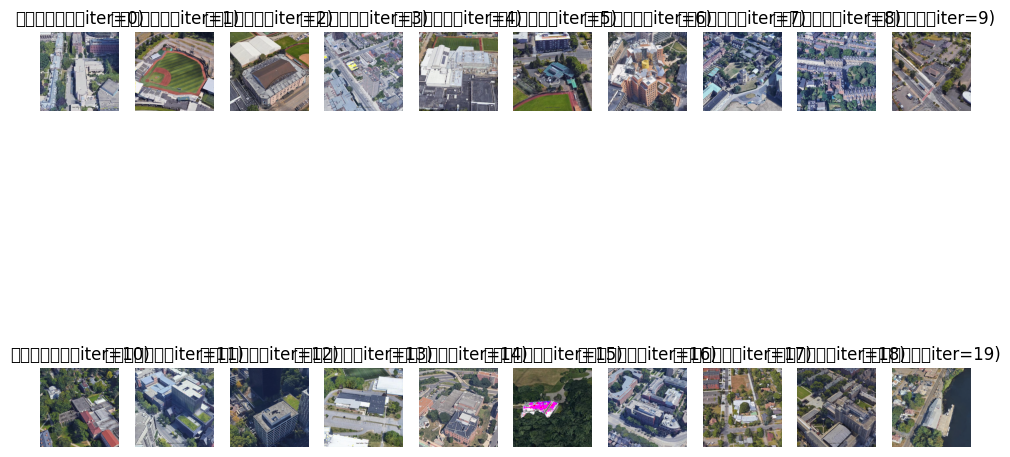

In [12]:
attack_dataset = DataLoader(new_dataset, batch_size=1, shuffle=True)
# 创建数据加载器（全部作为训练集，不划分验证集）
# attack_train_loader = DataLoader(attack_dataset, batch_size=32, shuffle=True, num_workers=2)

# ------------------- 初始化模型、损失函数和优化器 -------------------
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
blackbox_net = blackbox_attack(num_classes=751).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(blackbox_net.parameters(), lr=0.001)
epochs = 20
history_attack = []
# ------------------- 训练循环 -------------------
for epoch in range(epochs):
    # 训练阶段
    blackbox_net.train()
    train_loss = 0.0
    for batch_idx, (model_output, preprocessed_tensor) in enumerate(attack_dataset):#
        ##model_output, preprocessed_tensor形状分别为数据形状: torch.Size([1, 64, 192, 192]), 标签形状: torch.Size([1, 3, 384, 384])
        model_output = model_output.to(device)
        preprocessed_tensor = preprocessed_tensor.to(device)
        
        # 前向传播
        outputs = blackbox_net(model_output)
        loss = criterion(outputs, preprocessed_tensor)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # train_loss += loss.item() * model_output.size(0)
    history_attack.append(tp(outputs[0].cpu()))
    print(f"epoch {epoch} loss value:{loss}")
    
torch.save(blackbox_net.state_dict(), 'w_attack.pth')
print("训练完成！最终模型已保存至 w_attack.pth")   
plt.figure(figsize=(12, 8))
for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.imshow(history_attack[i])
    plt.title("虚拟图片展示（iter=%d)" % (i))
    plt.axis('off')


# 保存最终模型


In [13]:
reverse_transform = transforms.Compose([
    transforms.Normalize(mean=[0, 0, 0], std=[1/0.229, 1/0.224, 1/0.225]),
    transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
])


findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Micro Hei
findfont: Generic family 'sans-serif' not found 

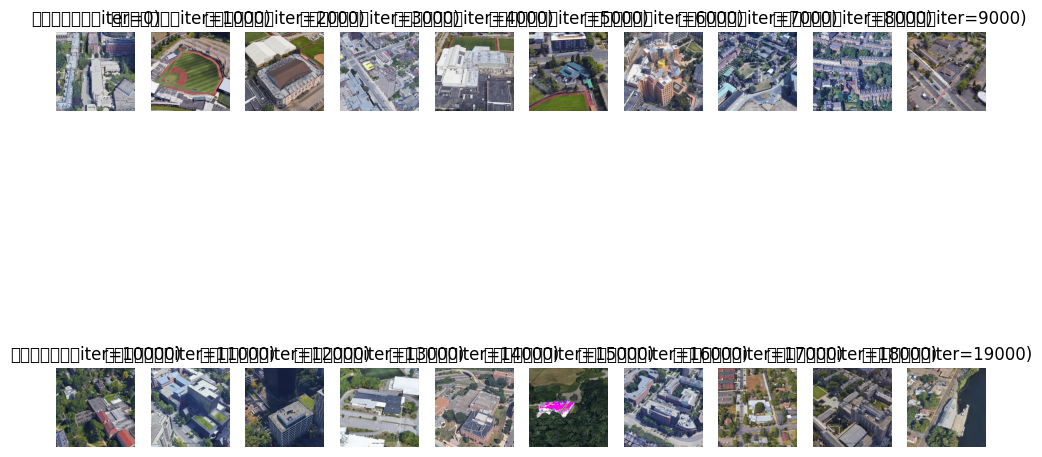

In [14]:
plt.figure(figsize=(12, 8))
for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.imshow(history_attack[i])
    plt.title("虚拟图片展示（iter=%d)" % (i * 1000))
    plt.axis('off')

plt.show()
